In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib qt

Gradient decay
==========================================

Some results worth saving and displaying for visualization and understanding

1/ Decay of gradient variances with increasing qubit count
---------------------------

First importing the relevant packages

In [2]:
import sys
sys.path.append('../src')
sys.path.append('src')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator
from matplotlib.lines import Line2D
import numpy as np
from data_management import get_training_costs, get_training_labels2

data_folder = '../../results/data/'

colours = np.array([plt.cm.Purples(np.linspace(0, 1, 6)),          # global
                    plt.cm.Blues(np.linspace(0, 1, 6)),            # local
                    plt.cm.Oranges(np.linspace(0, 1, 6)),          # gadget2
                    plt.cm.Reds(np.linspace(0, 1, 6)),             # gadget3
                    plt.cm.Greys(np.linspace(0, 1, 6))])[:, 1:]    # legends

Exponential decay of the global Hamiltonian
$$H_G = \bigotimes_{i=1}^n \sigma_i^z $$

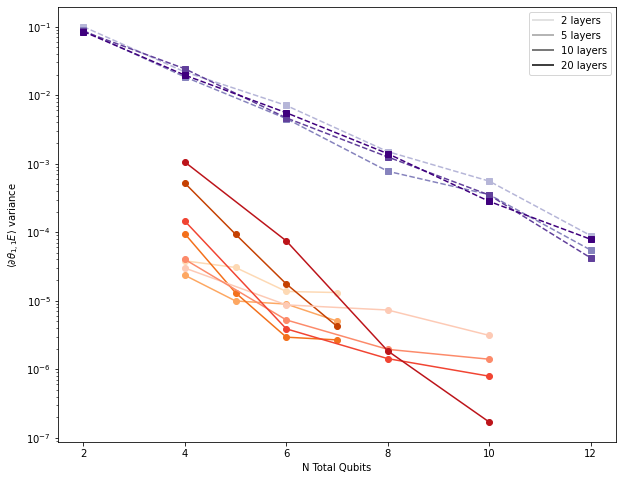

In [3]:
file_comp = data_folder + 'gradients/220707/gradients_nr0001.npz'
file_gad3 = data_folder + 'gradients/220708_euler/gradients_nr0001.npz'
file_gad4 = data_folder + 'gradients/220708_qmio/gradients_nr0002.npz'
layers_list = [2, 5, 10, 20]

data = np.load(file_comp)
variances_list = data['variances_list']
norms_list = data['norms_list']
qubits_list = data['width_list']

plt.rcParams["figure.figsize"] = 10, 8
fig, ax = plt.subplots(num=1, clear=True)
for line in range(1, len(variances_list)-1):
    normalized_variances = variances_list[line]/norms_list**2
    ax.semilogy(qubits_list, normalized_variances, "--s", c=colours[0][line])

data = np.load(file_gad3)
variances_list = data['variances_list']
norms_list = data['norms_list']
qubits_list = data['computational_qubits'][:4]

for line in range(len(variances_list)):
    # normalized_variances = variances_list[line]/norms_list**2
    normalized_variances = variances_list[line]
    ax.semilogy(qubits_list, normalized_variances, "-o", c=colours[2][line])

data = np.load(file_gad4)
variances_list = data['variances_list']
norms_list = data['norms_list']
qubits_list = data['computational_qubits'][:4]

for line in range(len(variances_list)):
    # normalized_variances = variances_list[line]/norms_list**2
    normalized_variances = variances_list[line]
    ax.semilogy(qubits_list, normalized_variances, "-o", c=colours[3][line])

ax.set_xlabel(r"N Total Qubits")
ax.set_ylabel(r"$\langle \partial \theta_{1, 1} E\rangle$ variance")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

custom_lines = [Line2D([0], [0], color=colours[-1][nl], lw=2) for nl in range(len(layers_list))]
ax.legend(custom_lines, ['{} layers'.format(num_layers) for num_layers in layers_list])

In [4]:
def get_vars_for_plot(file, max_qubit=np.inf, gradient_type='first'):
    data = np.load(file, allow_pickle=True)
    qubits_list = data['computational_qubits'][:len(data['widths_list'])]
    layers_list = data['layers_list']
    norms_list = data['norms_list']
    gradients_dict = data['all_gradients'].item()
    variances_list=[[] for _ in range(len(layers_list))]
    cutoff_index = np.where(qubits_list == max_qubit)
    if np.shape(cutoff_index[0]) == (1,):
        widths_range = qubits_list[:cutoff_index[0][0]+1]
    else: 
        widths_range = qubits_list
    for width in widths_range:
        for nl, depth in enumerate(layers_list):
            full_gradient = np.array(gradients_dict[(width, depth)])
            param_count = np.prod(np.shape(full_gradient[1:]))
            if gradient_type == 'one norm':
                variances_list[nl].append(np.var(np.sum(np.abs(full_gradient), axis=(1,2))) / param_count)
            if gradient_type == 'two norm':
                variances_list[nl].append(np.var(np.linalg.norm(full_gradient, 'fro', axis=(1,2))) / np.sqrt(param_count))
            if gradient_type == 'first':
                variances_list[nl].append(np.var(full_gradient[:, 0, 0]))
            if gradient_type == 'last comp':
                variances_list[nl].append(np.var(full_gradient[:, 0, width-1]))
            if gradient_type == 'half':
                variances_list[nl].append(np.var(full_gradient[:, 0, int(np.floor(width/2))]))
    print('variances from {:5d} samples'.format(np.shape(full_gradient)[0]))
    return widths_range, norms_list, variances_list

variances from  1000 samples
variances from  1000 samples
variances from  1000 samples


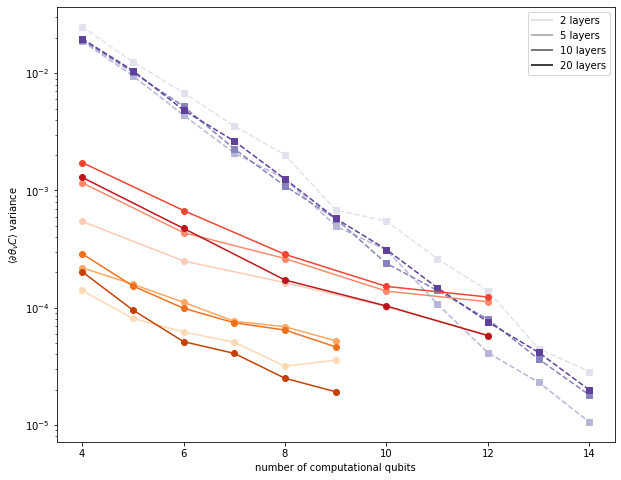

In [5]:
file_comp = data_folder + 'gradients/220711_qmio/gradients_nr0002.npz'
file_gad3 = data_folder + 'gradients/220725_euler/gradients_nr0002_merge.npz'
file_gad4 = data_folder + 'gradients/220728_euler/gradients_nr0001_merge.npz'

plt.rcParams["figure.figsize"] = 10, 8
fig, ax = plt.subplots(num=2, clear=True)

qubits_list, norms_list, variances_list = get_vars_for_plot(file_comp, gradient_type='last comp')
for line in range(len(variances_list)):
    normalized_variances = variances_list[line]/norms_list**2
    ax.semilogy(qubits_list, normalized_variances, "--s", c=colours[0][line])

qubits_list, norms_list, variances_list = get_vars_for_plot(file_gad3, gradient_type='last comp')
for line in range(len(variances_list)):
    normalized_variances = variances_list[line]/norms_list**2
    ax.semilogy(qubits_list, normalized_variances, "-o", c=colours[2][line])

qubits_list, norms_list, variances_list = get_vars_for_plot(file_gad4, gradient_type='last comp')
for line in range(len(variances_list)):
    normalized_variances = variances_list[line]/norms_list**2
    ax.semilogy(qubits_list, normalized_variances, "-o", c=colours[3][line])

ax.set_xlabel(r"number of computational qubits")
ax.set_ylabel(r"$\langle \partial \theta_{\nu} C\rangle$ variance")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

custom_lines = [Line2D([0], [0], color=colours[-1][nl], lw=2) for nl in range(len(layers_list))]
ax.legend(custom_lines, ['{} layers'.format(num_layers) for num_layers in layers_list])

variances from  1000 samples
variances from  1000 samples
variances from  1000 samples


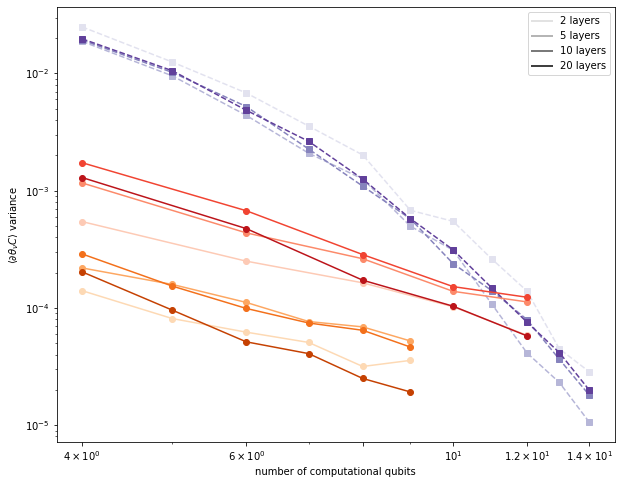

In [6]:
plt.rcParams["figure.figsize"] = 10, 8
fig, ax = plt.subplots(num=2, clear=True)

qubits_list, norms_list, variances_list = get_vars_for_plot(file_comp, gradient_type='last comp')
for line in range(len(variances_list)):
    normalized_variances = variances_list[line]/norms_list**2
    ax.loglog(qubits_list, normalized_variances, "--s", c=colours[0][line])

qubits_list, norms_list, variances_list = get_vars_for_plot(file_gad3, gradient_type='last comp')
for line in range(len(variances_list)):
    normalized_variances = variances_list[line]/norms_list**2
    ax.loglog(qubits_list, normalized_variances, "-o", c=colours[2][line])

qubits_list, norms_list, variances_list = get_vars_for_plot(file_gad4, gradient_type='last comp')
for line in range(len(variances_list)):
    normalized_variances = variances_list[line]/norms_list**2
    ax.loglog(qubits_list, normalized_variances, "-o", c=colours[3][line])

ax.set_xlabel(r"number of computational qubits")
ax.set_ylabel(r"$\langle \partial \theta_{\nu} C\rangle$ variance")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

custom_lines = [Line2D([0], [0], color=colours[-1][nl], lw=2) for nl in range(len(layers_list))]
ax.legend(custom_lines, ['{} layers'.format(num_layers) for num_layers in layers_list])

variances from  1000 samples
variances from  1000 samples


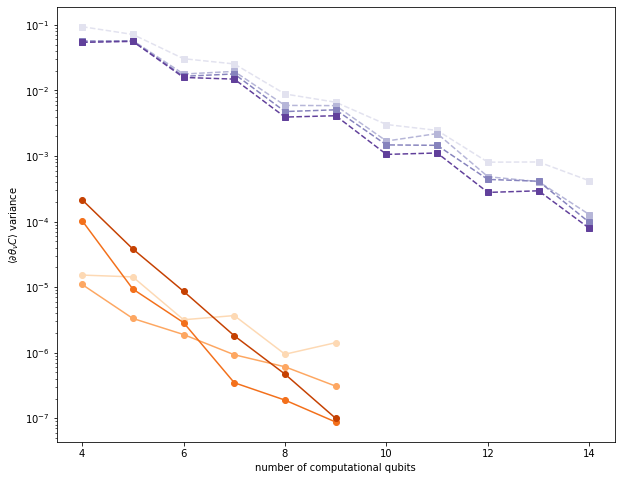

In [7]:
file_comp = data_folder + 'gradients/220801/gradients_nr0001.npz'
file_gad3 = data_folder + 'gradients/220802/gradients_nr0001.npz'
# file_gad4 = data_folder + 'gradients/220728_euler/gradients_nr0001_merge.npz'

plt.rcParams["figure.figsize"] = 10, 8
fig, ax = plt.subplots(num=2, clear=True)

qubits_list, norms_list, variances_list = get_vars_for_plot(file_comp, gradient_type='first')
for line in range(len(variances_list)):
    normalized_variances = variances_list[line]/norms_list**2
    ax.semilogy(qubits_list, normalized_variances, "--s", c=colours[0][line])

qubits_list, norms_list, variances_list = get_vars_for_plot(file_gad3, gradient_type='first')
for line in range(len(variances_list)):
    normalized_variances = variances_list[line]/norms_list**2
    ax.semilogy(qubits_list, normalized_variances, "-o", c=colours[2][line])

# qubits_list, norms_list, variances_list = get_vars_for_plot(file_gad4)
# for line in range(len(variances_list)):
#     normalized_variances = variances_list[line]/norms_list**2
#     ax.semilogy(qubits_list, normalized_variances, "-o", c=colours[3][line])

ax.set_xlabel(r"number of computational qubits")
ax.set_ylabel(r"$\langle \partial \theta_{\nu} C\rangle$ variance")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

variances from  1000 samples
variances from  1000 samples
variances from  1000 samples


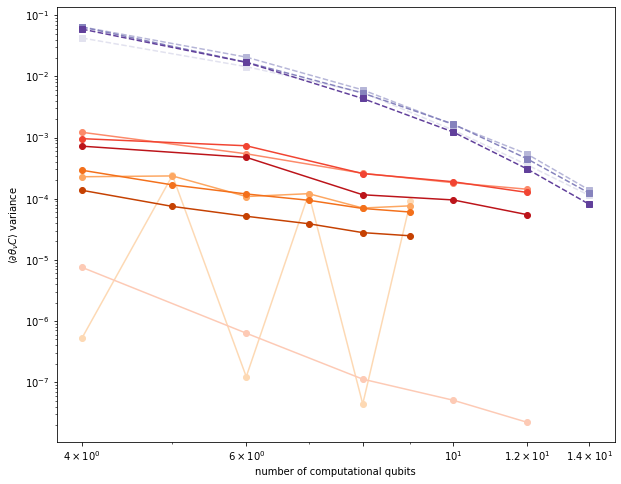

In [8]:
file_comp = data_folder + 'gradients/220810/gradients_nr0001.npz'
file_gad3 = data_folder + 'gradients/220821/gradients_nr0001.npz'
file_gad4 = data_folder + 'gradients/220821/gradients_nr0002.npz'
gtype = 'last comp'

plt.rcParams["figure.figsize"] = 10, 8
fig, ax = plt.subplots(num=2, clear=True)

qubits_list, norms_list, variances_list = get_vars_for_plot(file_comp, gradient_type=gtype)
for line in range(len(variances_list)):
    normalized_variances = variances_list[line]/norms_list**2
    ax.loglog(qubits_list, normalized_variances, "--s", c=colours[0][line])

qubits_list, norms_list, variances_list = get_vars_for_plot(file_gad3, gradient_type=gtype)
for line in range(len(variances_list)):
    normalized_variances = variances_list[line]/norms_list**2
    ax.loglog(qubits_list, normalized_variances, "-o", c=colours[2][line])

qubits_list, norms_list, variances_list = get_vars_for_plot(file_gad4, gradient_type=gtype)
for line in range(len(variances_list)):
    normalized_variances = variances_list[line]/norms_list**2
    ax.loglog(qubits_list, normalized_variances, "-o", c=colours[3][line])

ax.set_xlabel(r"number of computational qubits")
ax.set_ylabel(r"$\langle \partial \theta_{\nu} C\rangle$ variance")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

Training
=======

3-local gadget decomposition
---------------------

In [9]:
def plot_single_training(file):
    plt.rcParams["figure.figsize"] = 5, 4
    costs = get_training_costs(file + '.npz')
    labels = get_training_labels2(file + '.txt')
    colors = plt.cm.rainbow(np.linspace(0, 1, len(costs)-1))
    fig, ax1 = plt.subplots()
    # ax2 = ax1.twinx()
    ax1.plot(np.ones(len(costs[0])), ':', c='gainsboro')
    ax1.plot(-np.ones(len(costs[0])), ':', c='gainsboro')
    ax1.plot(np.zeros(len(costs[0])), ':', c='gainsboro')
    for i in range(1, len(costs)):
        ax1.plot(costs[i],'-', c=colors[i-1], label=labels[i])
    ax1.plot(costs[0],':', c='grey', label='Training')
    ax1.legend()
    ax1.set_xlabel('iterations')
    ax1.set_ylabel('computational cost')
    print('Final training cost: {:4.8f}'.format(costs[0][-1]))

$\lambda = \lambda_{max}$

In [10]:
# file_list = ['220707/training_nr0001', '220707/training_nr0002', 
#              '220707/training_nr0003', '220707/training_nr0004']
# for file in file_list:
#     plot_single_training(data_folder + '/training/' + file)

$\lambda = 5\lambda_{max}$

In [11]:
file_list = ['220708/training_nr0005', '220708/training_nr0002', 
             '220708/training_nr0003', '220708/training_nr0004']
# for file in file_list:
#     plot_single_training(data_folder + '/training/' + file)

$n=4$

Final training cost:   0.00001298     | computational cost:  -0.25973984
Final training cost:  -0.00025094     | computational cost:   0.23301379
Final training cost:  -0.00021870     | computational cost:  -0.23847598
Final training cost:  -0.14522643     | computational cost:  -0.31854981
Final training cost:  -0.91028520     | computational cost:  -0.99928466
Final training cost:   0.06671576     | computational cost:   0.58278553
Final training cost:   0.00041539     | computational cost:   0.03756004
Final training cost:  -0.00175549     | computational cost:  -0.07174805
Final training cost:  -0.17663602     | computational cost:  -0.77669247
Final training cost:  -0.49010252     | computational cost:  -0.99961043
Final training cost:  -0.00000748     | computational cost:   0.19476967
Final training cost:  -0.00059300     | computational cost:  -0.14742277
Final training cost:  -0.00120323     | computational cost:  -0.71602224
Final training cost:  -0.13603885     | computation

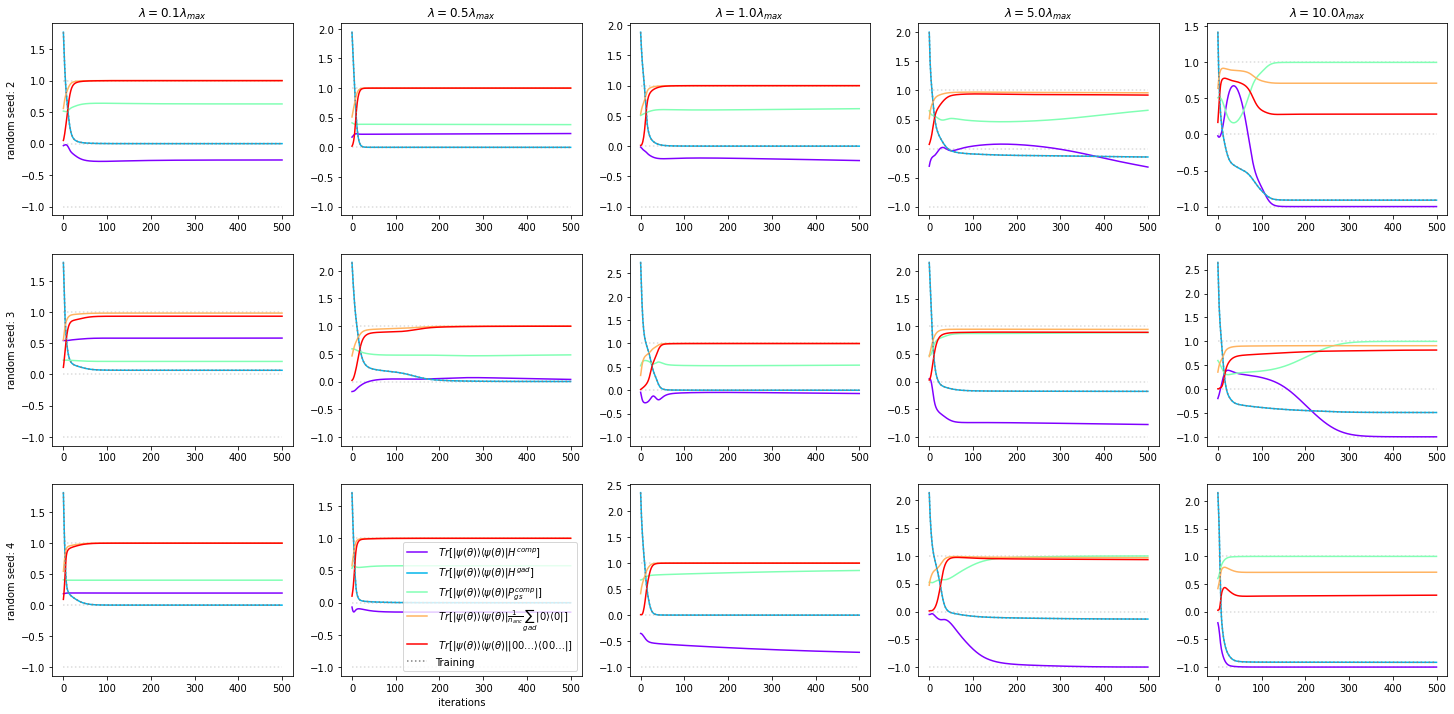

In [12]:
lambdas = [0.1, 0.5, 1, 5, 10]
seeds = [2, 3, 4]

plt.rcParams["figure.figsize"] = 25, 12
fig, axs = plt.subplots(3, 5)
for s, seed in enumerate(seeds):
    for l, lamb in enumerate(lambdas):
        count = 12 + s * len(lambdas) + (l+1)
        file = data_folder + '/training/' + '220708_euler/training_nr00{}'.format(count)
        costs = get_training_costs(file + '.npz')
        labels = get_training_labels2(file + '.txt')
        colors = plt.cm.rainbow(np.linspace(0, 1, len(costs)-1))
        axs[s, l].plot(np.ones(len(costs[0])), ':', c='gainsboro')
        axs[s, l].plot(-np.ones(len(costs[0])), ':', c='gainsboro')
        axs[s, l].plot(np.zeros(len(costs[0])), ':', c='gainsboro')
        for i in range(1, len(costs)):
            axs[s, l].plot(costs[i],'-', c=colors[i-1], label=labels[i])
        axs[s, l].plot(costs[0],':', c='grey', label='Training')
        if count == 24:
            axs[s, l].legend()
            axs[s, l].set_xlabel('iterations')
        if s == 0:
            axs[s, l].set_title(r'$\lambda = {:.1f}$'.format(lamb) + r'$\lambda_{max}$')
        if l == 0:
            axs[s, l].set_ylabel('random seed: {}'.format(seed))
        print('Final training cost: {:12.8f}'.format(costs[0][-1]), 
              '    | computational cost: {:12.8f}'.format(costs[1][-1]))

$n=6$

Final training cost:   0.00018029     | computational cost:   0.26106108
Final training cost:   0.00058914     | computational cost:   0.09237195
Final training cost:  -0.00009592     | computational cost:  -0.03166329
Final training cost:  -0.08432139     | computational cost:   0.09345411
Final training cost:  -0.31223371     | computational cost:   0.86565908
Final training cost:   0.00000812     | computational cost:   0.05105360
Final training cost:   0.00013801     | computational cost:   0.04762965
Final training cost:   0.00034746     | computational cost:  -0.00875842
Final training cost:  -0.07296964     | computational cost:  -0.23735035
Final training cost:  -0.42756944     | computational cost:  -0.81783841
Final training cost:   0.00005191     | computational cost:  -0.00516930
Final training cost:   0.00653056     | computational cost:  -0.02046882
Final training cost:  -0.00018410     | computational cost:   0.13468111
Final training cost:  -0.06567571     | computation

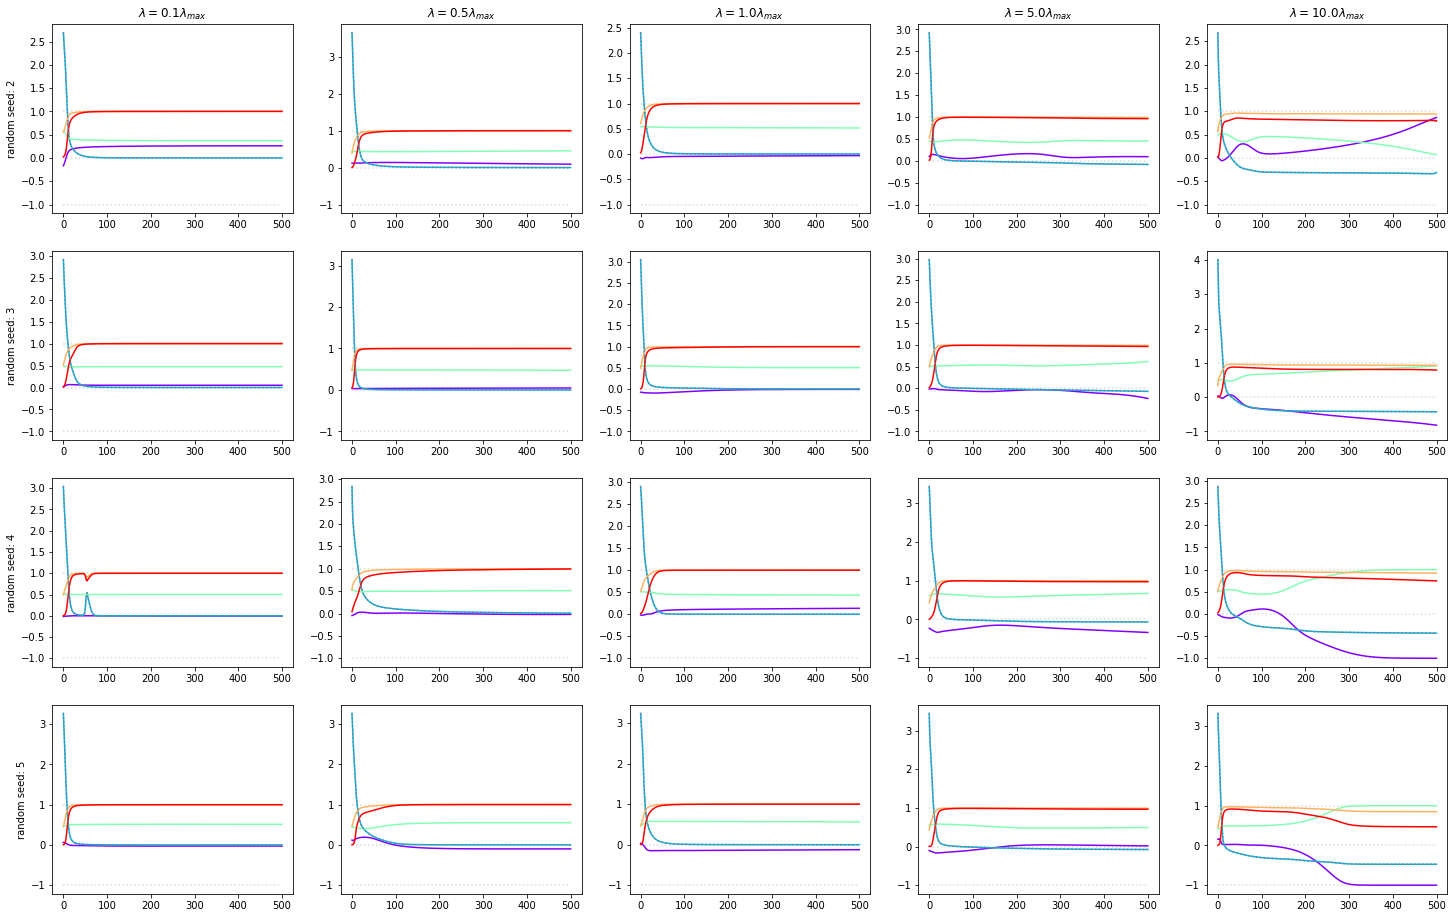

In [13]:
lambdas = [0.1, 0.5, 1, 5, 10]
seeds = [2, 3, 4, 5]
file_list = ['220712_qmio/training_nr{:0>4}'.format(nr) for nr in range(1, 12)]
file_list += ['220713_qmio/training_nr{:0>4}'.format(nr) for nr in range(1, 10)]

plt.rcParams["figure.figsize"] = 25, 16
fig, axs = plt.subplots(4, 5)
for s, seed in enumerate(seeds):
    for l, lamb in enumerate(lambdas):
        count = s * len(lambdas) + l
        file = data_folder + '/training/' + file_list[count]
        costs = get_training_costs(file + '.npz')
        labels = get_training_labels2(file + '.txt')
        colors = plt.cm.rainbow(np.linspace(0, 1, len(costs)-1))
        axs[s, l].plot(np.ones(len(costs[0])), ':', c='gainsboro')
        axs[s, l].plot(-np.ones(len(costs[0])), ':', c='gainsboro')
        axs[s, l].plot(np.zeros(len(costs[0])), ':', c='gainsboro')
        for i in range(1, len(costs)):
            axs[s, l].plot(costs[i],'-', c=colors[i-1], label=labels[i])
        axs[s, l].plot(costs[0],':', c='grey', label='Training')
        if count == 24:
            axs[s, l].legend()
            axs[s, l].set_xlabel('iterations')
        if s == 0:
            axs[s, l].set_title(r'$\lambda = {:.1f}$'.format(lamb) + r'$\lambda_{max}$')
        if l == 0:
            axs[s, l].set_ylabel('random seed: {}'.format(seed))
        print('Final training cost: {:12.8f}'.format(costs[0][-1]), 
              '    | computational cost: {:12.8f}'.format(costs[1][-1]))

8 computational qubits, 4-local gadget

Final training cost:   0.00008453     | computational cost:  -0.09298744
Final training cost:   0.00019885     | computational cost:  -0.02108473
Final training cost:   0.00021533     | computational cost:   0.00239078
Final training cost:  -0.02372653     | computational cost:   0.14916458
Final training cost:  -0.13779007     | computational cost:   0.43660413
Final training cost:   0.00002290     | computational cost:   0.02910731
Final training cost:   0.00000151     | computational cost:   0.01730310
Final training cost:   0.00036479     | computational cost:  -0.00569411
Final training cost:  -0.01256938     | computational cost:   0.02953797
Final training cost:  -0.20334047     | computational cost:  -0.94772859
Final training cost:   0.00014616     | computational cost:   0.01133600
Final training cost:   0.00029656     | computational cost:  -0.03355594
Final training cost:  -0.00001924     | computational cost:   0.00887264
Final training cost:  -0.02634560     | computation

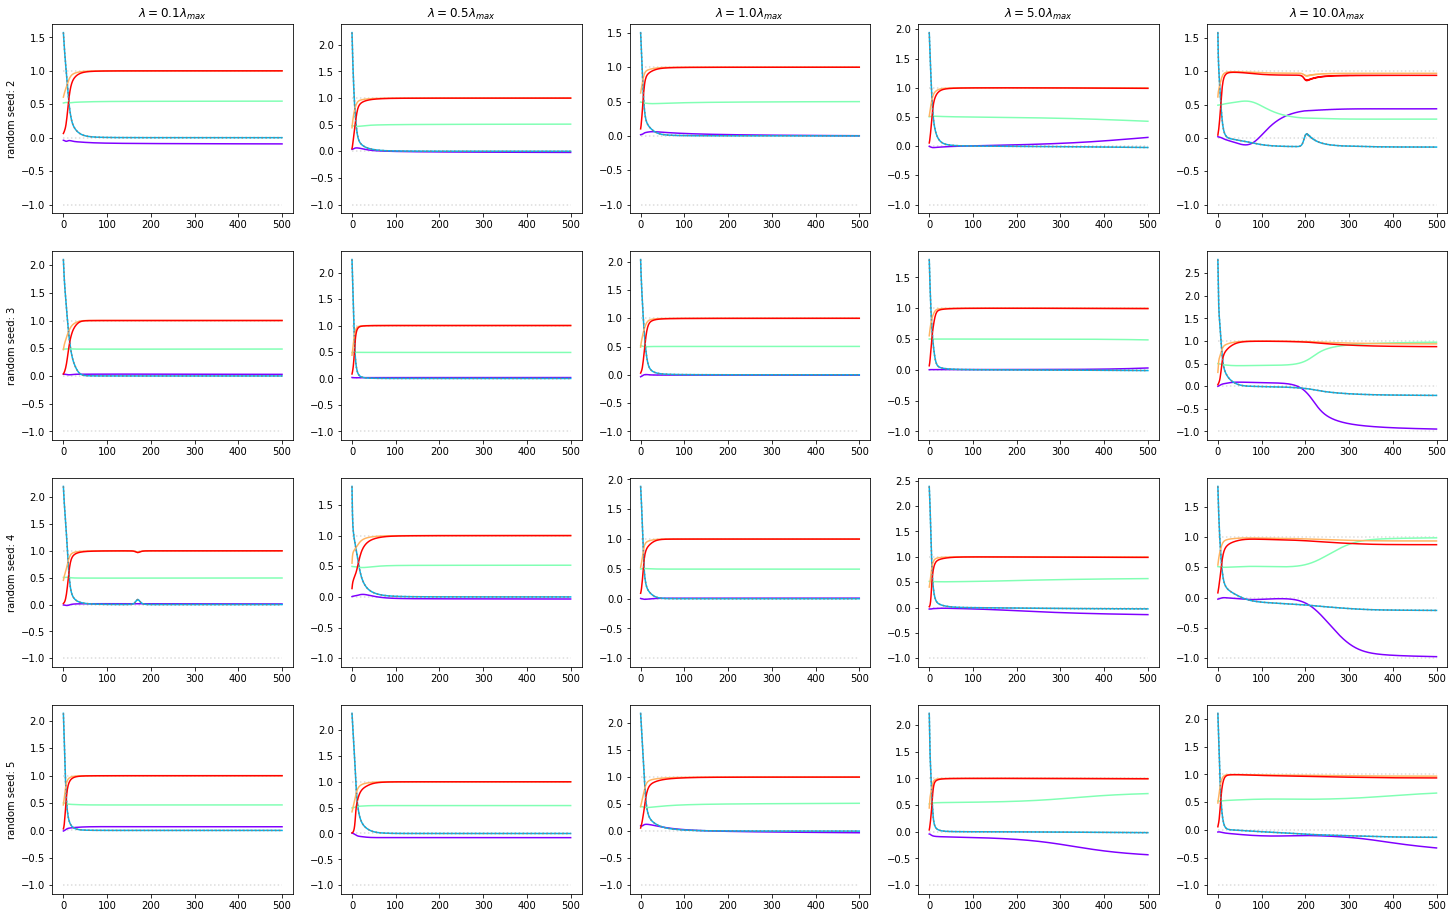

In [14]:
lambdas = [0.1, 0.5, 1, 5, 10]
seeds = [2, 3, 4, 5]
file_list = ['220719/training_nr{:0>4}'.format(nr) for nr in range(1, 5)]
file_list += ['220720/training_nr{:0>4}'.format(nr) for nr in range(1, 12)]
file_list += ['220721/training_nr{:0>4}'.format(nr) for nr in range(1, 6)]

plt.rcParams["figure.figsize"] = 25, 16
fig, axs = plt.subplots(4, 5)
for s, seed in enumerate(seeds):
    for l, lamb in enumerate(lambdas):
        count = s * len(lambdas) + l
        file = data_folder + '/training/' + file_list[count]
        costs = get_training_costs(file + '.npz')
        labels = get_training_labels2(file + '.txt')
        colors = plt.cm.rainbow(np.linspace(0, 1, len(costs)-1))
        axs[s, l].plot(np.ones(len(costs[0])), ':', c='gainsboro')
        axs[s, l].plot(-np.ones(len(costs[0])), ':', c='gainsboro')
        axs[s, l].plot(np.zeros(len(costs[0])), ':', c='gainsboro')
        for i in range(1, len(costs)):
            axs[s, l].plot(costs[i],'-', c=colors[i-1], label=labels[i])
        axs[s, l].plot(costs[0],':', c='grey', label='Training')
        if count == 24:
            axs[s, l].legend()
            axs[s, l].set_xlabel('iterations')
        if s == 0:
            axs[s, l].set_title(r'$\lambda = {:.1f}$'.format(lamb) + r'$\lambda_{max}$')
        if l == 0:
            axs[s, l].set_ylabel('random seed: {}'.format(seed))
        print('Final training cost: {:12.8f}'.format(costs[0][-1]), 
              '    | computational cost: {:12.8f}'.format(costs[1][-1]))

Training statistics

In [15]:
palette = [['#e65e71', '#d64055', '#ba182e', '#851919'], 
           ['#77f2d8', '#64d4bc', '#3cb89d', '#279680'], 
           ['#00a1d9', '#1977c2', '#2041ba', '#202482'], 
           ['#b0b0b0', '#727272', '#606060', '#393939']]

In [16]:
def training_plots(file_list): 
    # lambdas = [0.1, 1, 10]
    lambdas = file_list.keys()
    palette_choice = [palette[0][2], palette[2][0]]

    plt.rcParams["figure.figsize"] = 24, 7
    plt.rcParams.update({
        "pgf.preamble": "\n".join([
            r"\usepackage{dsfont}", 
            r"\usepackage{amsmath}", 
        ])
    })
    fig, axs = plt.subplots(1, 3)

    iterations = 500
    for l, lamb in enumerate(lambdas):
        runs = len(file_list[lamb])
        print("perturbation factor: {:>6.1f}, number of trainings: {:>4}".format(lamb, runs))
        axs[l].plot(np.ones(iterations), ':', c='gainsboro')
        axs[l].plot(-np.ones(iterations), ':', c='gainsboro')
        axs[l].plot(np.zeros(iterations), ':', c='gainsboro')
        axs[l].set_title(r'$\lambda = {}$'.format(lamb) + r'$\lambda_{max}$', 
                         fontsize=9)
        axs[l].set_ylim(top=2)
        axs[0].set_ylabel('Cost')
        axs[1].set_xlabel('Number of iterations')
        costs_sum = 0
        for f, file in enumerate(file_list[lamb]):
            file = data_folder + 'training/' + file
            costs = get_training_costs(file + '.npz')
            costs_sum += costs
            for i in range(1, 3):
                axs[l].plot(costs[i],'-', c=palette_choice[i-1], alpha=1.5/runs)
        costs_mean = costs_sum / runs
        for i in range(1, 3):
            axs[l].plot(costs_mean[i],'-', c=palette_choice[i-1])

In [17]:
file_list = {}
file_list[0.1]  = ['220726_qmio11-1/training_nr{:0>4}'.format(nr) for nr in range(1, 11, 3)]
file_list[0.1] += ['220726_qmio14/training_nr{:0>4}'.format(nr) for nr in range(1, 11, 3)]
file_list[0.1] += ['220727_qmio11-1/training_nr{:0>4}'.format(nr) for nr in range(3, 21, 3)]
file_list[0.1] += ['220727_qmio11-2/training_nr{:0>4}'.format(nr) for nr in range(1, 31, 3)]
file_list[0.1] += ['220727_qmio14/training_nr{:0>4}'.format(nr) for nr in range(3, 33, 3)]
file_list[0.1] += ['220728_qmio11-1/training_nr{:0>4}'.format(nr) for nr in range(1, 20, 3)]
file_list[0.1] += ['220728_qmio11-2/training_nr{:0>4}'.format(nr) for nr in range(1, 20, 3)]
file_list[0.1] += ['220728_qmio14/training_nr{:0>4}'.format(nr) for nr in range(1, 40, 3)]
file_list[0.1] += ['220729_qmio11-1/training_nr{:0>4}'.format(nr) for nr in range(3, 12, 3)]
file_list[0.1] += ['220729_qmio11-2/training_nr{:0>4}'.format(nr) for nr in range(3, 12, 3)]
file_list[0.1] += ['220729_qmio14/training_nr{:0>4}'.format(nr) for nr in range(1, 10, 3)]

file_list[1]    = ['220726_qmio11-1/training_nr{:0>4}'.format(nr) for nr in range(2, 11, 3)]
file_list[1]   += ['220726_qmio14/training_nr{:0>4}'.format(nr) for nr in range(2, 11, 3)]
file_list[1]   += ['220727_qmio11-1/training_nr{:0>4}'.format(nr) for nr in range(1, 21, 3)]
file_list[1]   += ['220727_qmio11-2/training_nr{:0>4}'.format(nr) for nr in range(2, 31, 3)]
file_list[1]   += ['220727_qmio14/training_nr{:0>4}'.format(nr) for nr in range(1, 33, 3)]
file_list[1]   += ['220728_qmio11-1/training_nr{:0>4}'.format(nr) for nr in range(2, 20, 3)]
file_list[1]   += ['220728_qmio11-2/training_nr{:0>4}'.format(nr) for nr in range(2, 20, 3)]
file_list[1]   += ['220728_qmio14/training_nr{:0>4}'.format(nr) for nr in range(2, 40, 3)]
file_list[1]   += ['220729_qmio11-1/training_nr{:0>4}'.format(nr) for nr in range(1, 12, 3)]
file_list[1]   += ['220729_qmio11-2/training_nr{:0>4}'.format(nr) for nr in range(1, 12, 3)]
file_list[1]   += ['220729_qmio14/training_nr{:0>4}'.format(nr) for nr in range(2, 10, 3)]

file_list[10]   = ['220726_qmio11-1/training_nr{:0>4}'.format(nr) for nr in range(3, 11, 3)]
file_list[10]  += ['220726_qmio14/training_nr{:0>4}'.format(nr) for nr in range(3, 11, 3)]
file_list[10]  += ['220727_qmio11-1/training_nr{:0>4}'.format(nr) for nr in range(2, 21, 3)]
file_list[10]  += ['220727_qmio11-2/training_nr{:0>4}'.format(nr) for nr in range(3, 31, 3)]
file_list[10]  += ['220727_qmio14/training_nr{:0>4}'.format(nr) for nr in range(2, 33, 3)]
file_list[10]  += ['220728_qmio11-1/training_nr{:0>4}'.format(nr) for nr in range(3, 20, 3)]
file_list[10]  += ['220728_qmio11-2/training_nr{:0>4}'.format(nr) for nr in range(3, 20, 3)]
file_list[10]  += ['220728_qmio14/training_nr{:0>4}'.format(nr) for nr in range(3, 40, 3)]
file_list[10]  += ['220729_qmio11-1/training_nr{:0>4}'.format(nr) for nr in range(2, 12, 3)]
file_list[10]  += ['220729_qmio11-2/training_nr{:0>4}'.format(nr) for nr in range(2, 12, 3)]
file_list[10]  += ['220729_qmio14/training_nr{:0>4}'.format(nr) for nr in range(3, 10, 3)]

perturbation factor:    0.1, number of trainings:   70
perturbation factor:    1.0, number of trainings:   70
perturbation factor:   10.0, number of trainings:   70


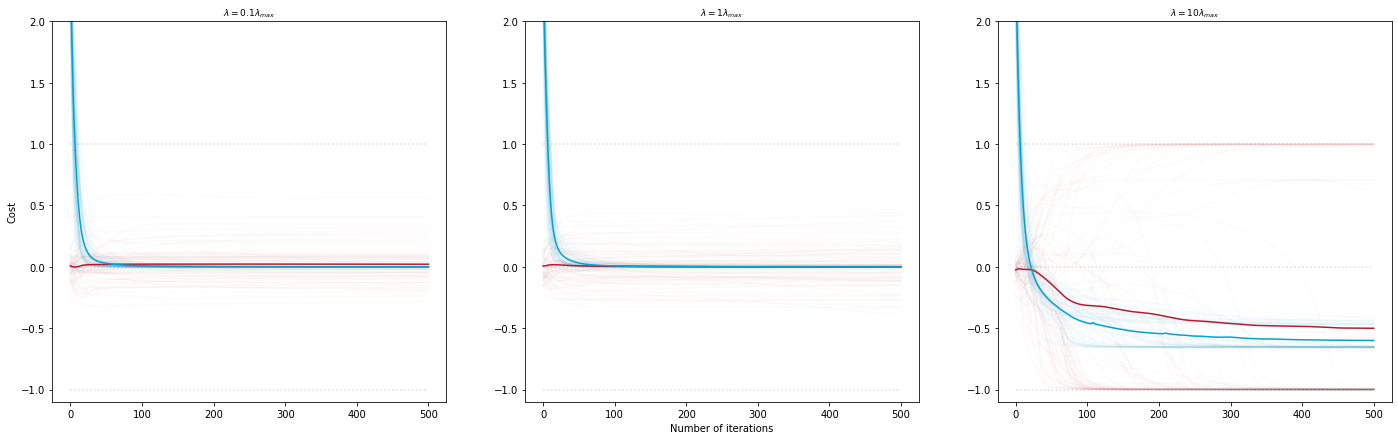

In [18]:
training_plots(file_list)

perturbation factor:    0.1, number of trainings:   20
perturbation factor:    1.0, number of trainings:   20
perturbation factor:   10.0, number of trainings:   20


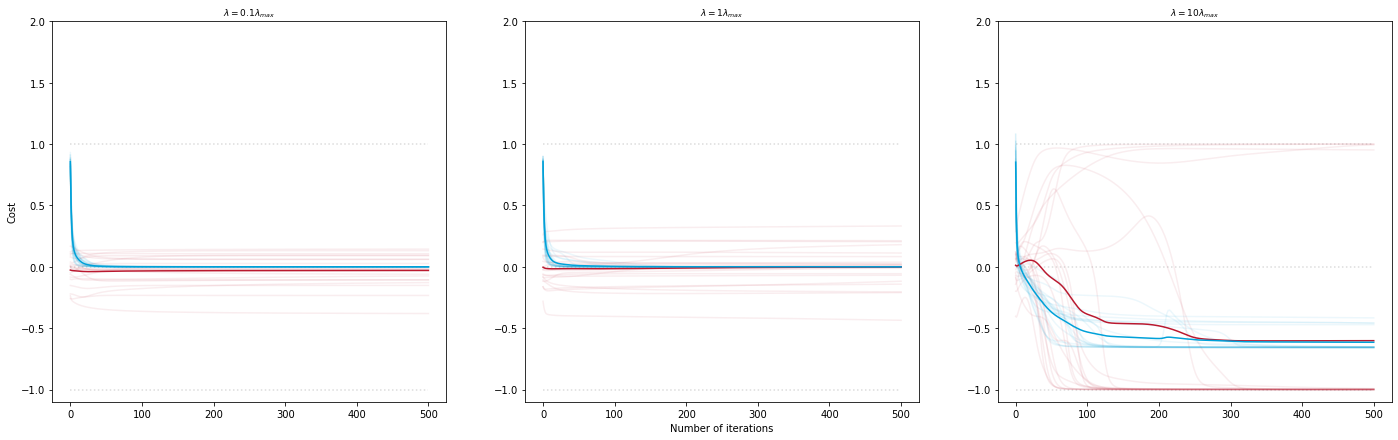

In [19]:
file_list = {}
file_list[0.1]  = ['220803/training_nr{:0>4}'.format(nr) for nr in range(1, 12, 3)]
file_list[1]    = ['220803/training_nr{:0>4}'.format(nr) for nr in range(2, 12, 3)]
file_list[10]   = ['220803/training_nr{:0>4}'.format(nr) for nr in range(3, 12, 3)]
file_list[0.1] += ['220804/training_nr{:0>4}'.format(nr) for nr in range(2, 40, 3)]
file_list[1]   += ['220804/training_nr{:0>4}'.format(nr) for nr in range(3, 40, 3)]
file_list[10]  += ['220804/training_nr{:0>4}'.format(nr) for nr in range(1, 40, 3)]
file_list[0.1] += ['220805/training_nr{:0>4}'.format(nr) for nr in range(2, 11, 3)]
file_list[1]   += ['220805/training_nr{:0>4}'.format(nr) for nr in range(3, 11, 3)]
file_list[10]  += ['220805/training_nr{:0>4}'.format(nr) for nr in range(1, 11, 3)]
training_plots(file_list)

With qubit reordering

perturbation factor:    0.1, number of trainings:   30
perturbation factor:    1.0, number of trainings:   30
perturbation factor:   10.0, number of trainings:   30


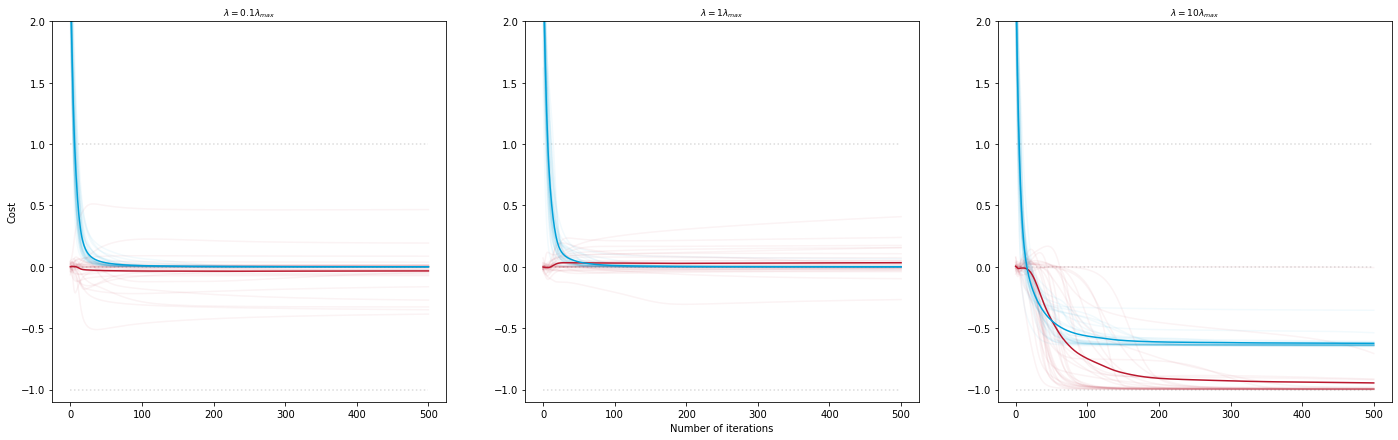

In [21]:
file_list = {}
file_list[0.1]  = ['220831/training_nr{:0>4}'.format(nr) for nr in range(1, 17, 3)]
file_list[1]    = ['220831/training_nr{:0>4}'.format(nr) for nr in range(2, 17, 3)]
file_list[10]   = ['220831/training_nr{:0>4}'.format(nr) for nr in range(3, 17, 3)]
file_list[0.1] += ['220901/training_nr{:0>4}'.format(nr) for nr in range(3, 47, 3)]
file_list[1]   += ['220901/training_nr{:0>4}'.format(nr) for nr in range(1, 47, 3)]
file_list[10]  += ['220901/training_nr{:0>4}'.format(nr) for nr in range(2, 47, 3)]
file_list[0.1] += ['220902/training_nr{:0>4}'.format(nr) for nr in range(2, 29, 3)]
file_list[1]   += ['220902/training_nr{:0>4}'.format(nr) for nr in range(3, 29, 3)]
file_list[10]  += ['220902/training_nr{:0>4}'.format(nr) for nr in range(1, 29, 3)]
training_plots(file_list)